In [8]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
health_dataset = pd.read_csv('/Users/jaco-pro/Documents/projects/exploreAI/data/healthcare-dataset-stroke-data.csv')

In [3]:
health_dataset.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
print(f"Shape of dataframe: {health_dataset.shape}")

Shape of dataframe: (5110, 12)


In [5]:
# Missing data in BMI column
health_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


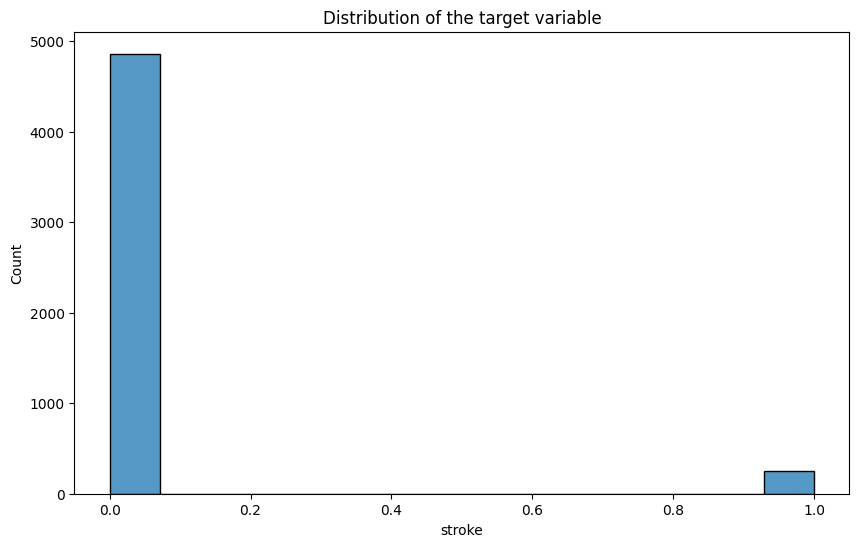

In [12]:
# Plot distribution of the target variable
# Note: Imbalanced problem
plt.figure(figsize=(10, 6))
sns.histplot(data=health_dataset, x='stroke', kde=False)
plt.title('Distribution of the target variable')
plt.show()


col:  id


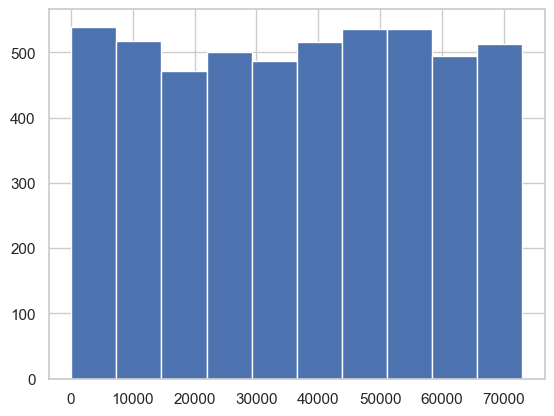

col:  gender


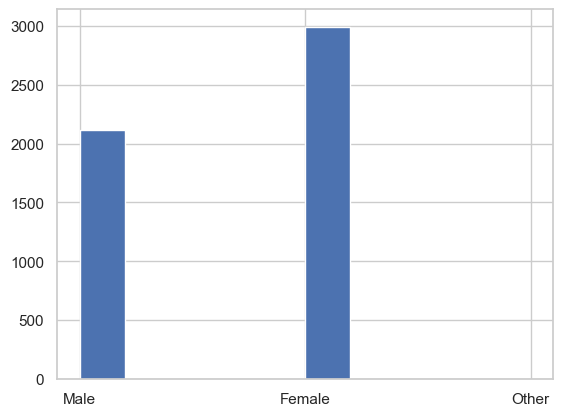

col:  age


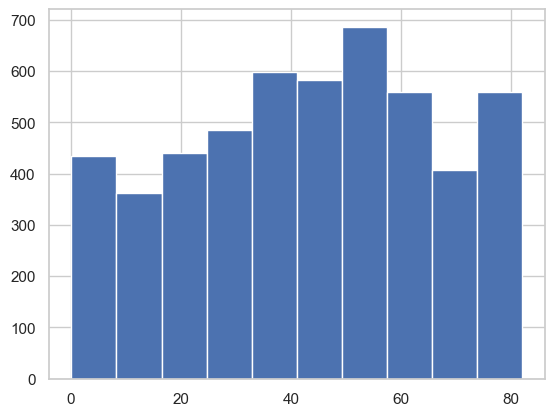

col:  hypertension


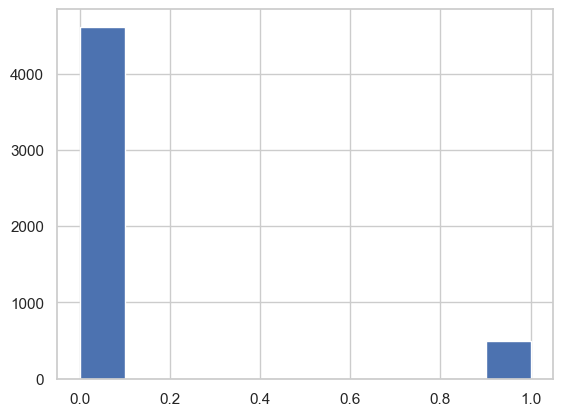

col:  heart_disease


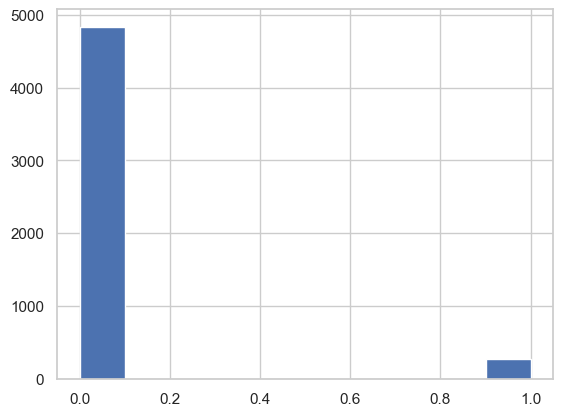

col:  ever_married


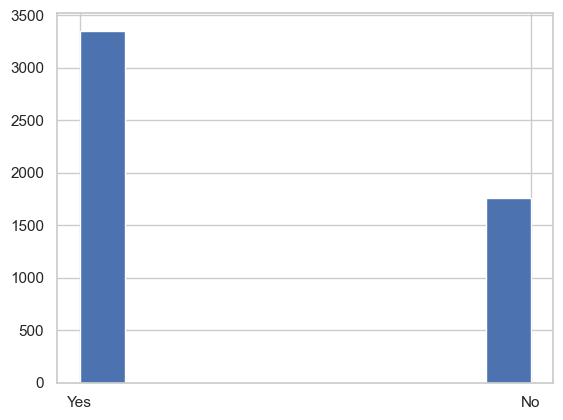

col:  work_type


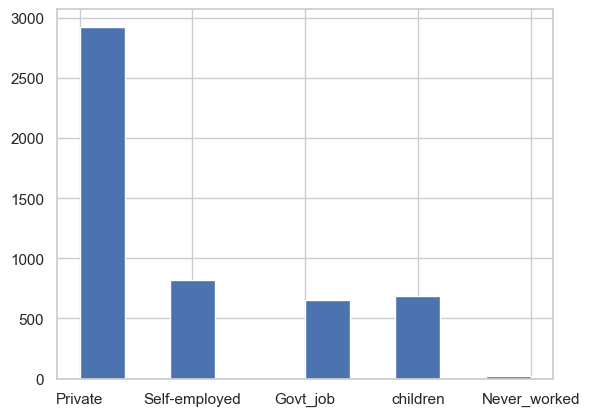

col:  Residence_type


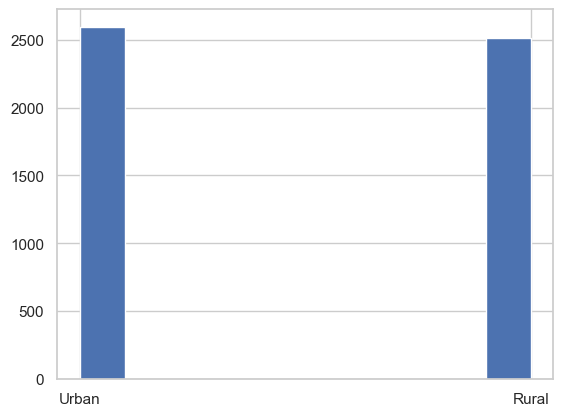

col:  avg_glucose_level


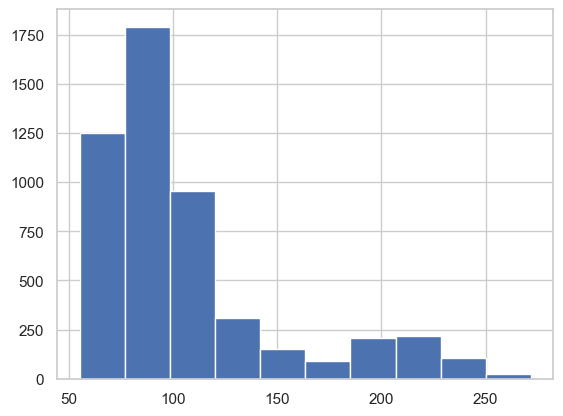

col:  bmi


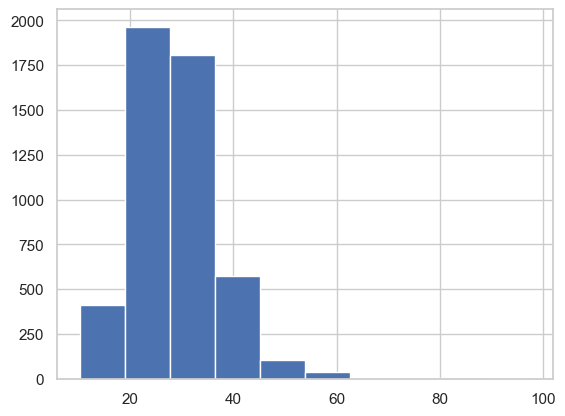

col:  smoking_status


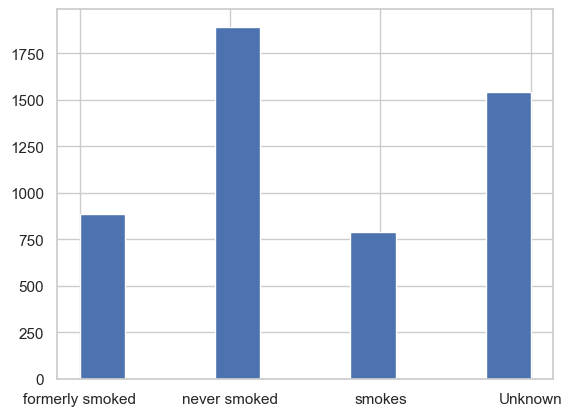

col:  stroke


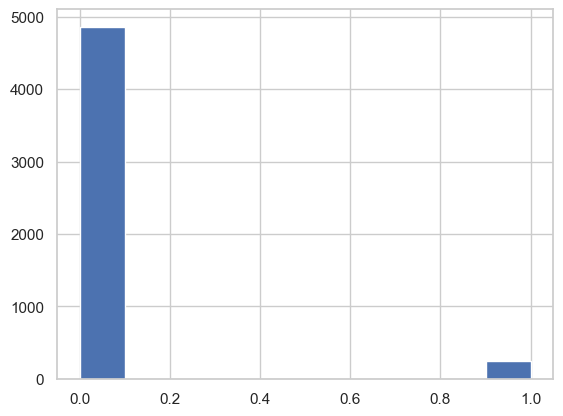

<Figure size 640x480 with 0 Axes>

In [15]:
#plot the distribution of the features in the dataset, seperated by the target variable
# %% Show histogram for all columns
columns = health_dataset.columns
for col in columns:
    print("col: ", col)
    health_dataset[col].hist()
    plt.show()
    # plot next to each other
    plt.tight_layout()




In [1]:


def load_breast_data():
    breast = load_breast_cancer()
    feature_names = list(breast.feature_names)
    X, y = pd.DataFrame(breast.data, columns=feature_names), breast.target
    dataset = {
        'problem': 'classification',
        'full': {
            'X': X,
            'y': y,
        },
    }
    return dataset


def load_adult_data():
    df = pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
        header=None)
    df.columns = [
        "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
        "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
        "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"
    ]
    train_cols = df.columns[0:-1]
    label = df.columns[-1]
    X_df = df[train_cols]
    y_df = df[label]

    dataset = {
        'problem': 'classification',
        'full': {
            'X': X_df,
            'y': y_df,
        },
    }

    return dataset

def load_heart_data():
    # https://www.kaggle.com/ronitf/heart-disease-uci
    df = pd.read_csv(r'C:\develop\data\heart-disease-uci\heart.csv')
    train_cols = df.columns[0:-1]
    label = df.columns[-1]
    X_df = df[train_cols]
    y_df = df[label]
    dataset = {
        'problem': 'classification',
        'full': {
            'X': X_df,
            'y': y_df,
        },
    }
    
    return dataset


def load_credit_data():
    # https://www.kaggle.com/mlg-ulb/creditcardfraud
    df = pd.read_csv(r'C:\develop\data\creditcardfraud\creditcard.csv')
    train_cols = df.columns[0:-1]
    label = df.columns[-1]
    X_df = df[train_cols]
    y_df = df[label]
    dataset = {
        'problem': 'classification',
        'full': {
            'X': X_df,
            'y': y_df,
        },
    }
    
    return dataset


def load_telco_churn_data():
    # https://www.kaggle.com/blastchar/telco-customer-churn/downloads/WA_Fn-UseC_-Telco-Customer-Churn.csv/1
    df = pd.read_csv(r'C:\develop\data\telco-customer-churn\WA_Fn-UseC_-Telco-Customer-Churn.csv')
    train_cols = df.columns[1:-1] # First column is an ID
    label = df.columns[-1]
    X_df = df[train_cols]
    y_df = df[label] # 'Yes, No'
    dataset = {
        'problem': 'classification',
        'full': {
            'X': X_df,
            'y': y_df,
        },
    }
    
    return dataset

ModuleNotFoundError: No module named 'numpy'